In [1]:
import os
import re
import random
import hashlib

from enum import Enum
from collections import ChainMap

import numpy as np
import pandas as pd

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from scipy.io import wavfile

import librosa

import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

In [2]:
#########
# Utils #
#########

class SimpleCache(dict):
    def __init__(self, limit):
        super().__init__()
        self.limit = limit
        self.n_keys = 0

    def __setitem__(self, key, value):
        if key in self.keys():
            super().__setitem__(key, value)
        elif self.n_keys < self.limit:
            self.n_keys += 1
            super().__setitem__(key, value)
        return value

class SerializableModule(nn.Module):
    def __init__(self):
        super().__init__()

    def save(self, filename):
        torch.save(self.state_dict(), filename)

    def load(self, filename):
        self.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))

def play_wav(wav_path):
    sample_rate, samples = wavfile.read(wav_path)
    return ipd.Audio(samples, rate=sample_rate)

In [3]:
class DatasetType(Enum):
    TRAIN = 0
    DEV = 1
    TEST = 2

In [4]:
def random_bg_noise(bg_noise):
    lst_of_bg_operations = ['linear_comb', 1, 2, 3, 4]
    choice = random.choice(lst_of_bg_operations)
    if choice == 'linear_comb':
        first_coef = random.uniform(0, 1)
        second_coef = 1-first_coef
        return first_coef * random.choice(bg_noise)[:960000] + second_coef * random.choice(bg_noise)[:960000]
    if choice == 1:
        return random.choice(bg_noise)[:960000]
    if choice == 2:
        return random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000]
    if choice == 3:
        return random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000] + \
               random.choice(bg_noise)[:960000]
    if choice == 4:
        return random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000] + \
               random.choice(bg_noise)[:960000] + random.choice(bg_noise)[:960000]
    

In [5]:
# useful PyTorch abstraction
class SpeechDataset(data.Dataset):
    def __init__(self, data, set_type, config):
        ####
        # data – {wave_file_path : label}
        # set_type – DatasetType (dev, train or test)
        # config.bg_noise_files – will be used to noise wavs during training (see preprocess func)
        ####
        super().__init__()
        self.audio_files = list(data.keys())
        self.audio_labels = list(data.values())
        self.set_type = set_type
        config["bg_noise_files"] = list(filter(lambda x: x.endswith("wav"), config.get("bg_noise_files", [])))
        self.bg_noise_audio = [librosa.core.load(file, sr=16000)[0] for file in config["bg_noise_files"]]
        self.unknown_prob = config["unknown_prob"]
        self.silence_prob = config["silence_prob"]
        self.noise_prob = config["noise_prob"]
        self.n_dct = config["n_dct_filters"]
        self.n_mels = config["n_mels"]
        self.input_length = config["input_length"]
        self.timeshift_ms = config["timeshift_ms"]
        self.filters = librosa.filters.dct(config["n_dct_filters"], config["n_mels"])
        self._audio_cache = SimpleCache(config["cache_size"])
        self._file_cache = SimpleCache(config["cache_size"])
        n_unk = len(list(filter(lambda x: x == 1, self.audio_labels)))
        self.n_silence = int(self.silence_prob * (len(self.audio_labels) - n_unk))
    
    # PyTorch needs this function
    def __getitem__(self, index):
        if index >= len(self.audio_labels):
            return self.preprocess(None, silence=True), 0
        return self.preprocess(self.audio_files[index]), self.audio_labels[index]
    
    # PyTorch needs this function
    def __len__(self):
        return len(self.audio_labels) + self.n_silence

    # Our extra functions go below:
    def _timeshift_audio(self, data):
        shift = (16000 * self.timeshift_ms) // 1000
        shift = random.randint(-shift, shift)
        a = -min(0, shift)
        b = max(0, shift)
        data = np.pad(data, (a, b), "constant")
        return data[:len(data) - a] if a else data[b:]
    
    def _preprocess_audio(self, data, n_mels, dct_filters):
        data = librosa.feature.melspectrogram(
            data, 
            sr=16000, 
            n_mels=n_mels, 
            hop_length=160, 
            n_fft=480, 
            fmin=20, 
            fmax=4000
        )
        data[data > 0] = np.log(data[data > 0])
        data = [np.matmul(dct_filters, x) for x in np.split(data, data.shape[1], axis=1)]
        data = np.array(data, order="F").squeeze(2).astype(np.float32)
        return data

    def preprocess(self, example, silence=False):
        if silence:
            example = "__silence__"
        if random.random() < 0.7:
            try:
                return self._audio_cache[example]
            except KeyError:
                pass
        
        in_len = self.input_length
        if self.bg_noise_audio:
            # take a random samples chunk of a random noise audio
            bg_noise  =  random_bg_noise(self.bg_noise_audio)
            a = random.randint(0, len(bg_noise) - in_len - 1)
            bg_noise = bg_noise[a:a + in_len]
        else:
            bg_noise = np.zeros(in_len)
        
        use_clean = (self.set_type != DatasetType.TRAIN)
        if use_clean:
            bg_noise = np.zeros(in_len)
        if silence:
            data = np.zeros(in_len, dtype=np.float32)
        else:
            file_data = self._file_cache.get(example)
            data = librosa.core.load(example, sr=16000)[0] if file_data is None else file_data
            self._file_cache[example] = data
        data = np.pad(data, (0, max(0, in_len - len(data))), "constant")
        if not use_clean:
            data = self._timeshift_audio(data)

        if random.random() < self.noise_prob or silence:
            a = random.random() * 0.1
            data = np.clip(a * bg_noise + data, -1, 1)
        data = torch.from_numpy(self._preprocess_audio(data, self.n_mels, self.filters))
        self._audio_cache[example] = data
        return data

### Define config

In [6]:
config = dict(
    data_folder="./../raw_data/train/audio",
    wanted_words="yes no up down left right on off stop go".split(),
    
    seed=0,
    
    output_file="./../models/model_updated_added_noise_mix_extended_40ep.pt", 
    gpu_no=0,
    cache_size=32768,
    
    n_epochs=40,
    momentum=0.9, 
    weight_decay=0.00001,
    lr=[0.1, 0.01, 0.001], 
    schedule=[3000, 6000], 
    batch_size=64, 
    dev_every=1,
    use_nesterov=False,
    
    group_speakers_by_id=True,
    
    silence_prob=0.25,
    noise_prob=0.85,
    unknown_prob=0.25, # percentage of unknown waves in the train/dev/test dataset
    
    input_length=16000,
    timeshift_ms=100,
    # Below are two parameters of Discrete Cosine Transform (http://en.wikipedia.org/wiki/Discrete_cosine_transform)
    n_dct_filters=40, 
    n_mels=40,
    
    train_pct=80,
    dev_pct=10,
    test_pct=10
)

In [7]:
seed = config["seed"]
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)

In [8]:
folder = config["data_folder"]
wanted_words = config["wanted_words"]
unknown_prob = config["unknown_prob"]
train_pct = config["train_pct"]
dev_pct = config["dev_pct"]
test_pct = config["test_pct"]

LABEL_UNKNOWN = "__unknown__"
LABEL_SILENCE = "__silence__"

words = {word: i + 2 for i, word in enumerate(wanted_words)}
words.update({LABEL_SILENCE:0, LABEL_UNKNOWN:1})
sets = [{}, {}, {}]  # [train, dev, test] => {wav_name: label}
unknowns = [0] * 3 # number of wavs for each dataset to take from collected unknown waves according to unknown_prob
bg_noise_files = []
unknown_files = []

In [9]:
words

{'__silence__': 0,
 '__unknown__': 1,
 'down': 5,
 'go': 11,
 'left': 6,
 'no': 3,
 'off': 9,
 'on': 8,
 'right': 7,
 'stop': 10,
 'up': 4,
 'yes': 2}

### prep datasets

In [10]:
max_no_wavs = 2**27 - 1

for folder_name in os.listdir(folder):
    print("Process " + folder_name)
    path_name = os.path.join(folder, folder_name)
    is_bg_noise = False
    
    # Skip files
    if os.path.isfile(path_name):
        continue
    
    # Assign the label based on the current folder name
    if folder_name in words:
        label = words[folder_name]
    elif folder_name == "_background_noise_":
        is_bg_noise = True
    else:
        label = words[LABEL_UNKNOWN]

    for filename in os.listdir(path_name):
        wav_name = os.path.join(path_name, filename)
        
        # Just record background noises files and continue
        if is_bg_noise and os.path.isfile(wav_name):
            bg_noise_files.append(wav_name)
            continue
        # collect wav names when label is unknown
        elif label == words[LABEL_UNKNOWN]:
            unknown_files.append(wav_name)
            continue
        
        # Fill sets with {wave_name : label}
        if config["group_speakers_by_id"]:
            hashname = re.sub(r"_nohash_.*$", "", filename)
            bucket = int(hashlib.sha1(hashname.encode()).hexdigest(), 16)
            bucket = (bucket % (max_no_wavs + 1)) * (100. / max_no_wavs)
            if bucket < dev_pct:
                tag = DatasetType.DEV
            elif bucket < test_pct + dev_pct:
                tag = DatasetType.TEST
            else:
                tag = DatasetType.TRAIN
            sets[tag.value][wav_name] = label
        else:
            raise NotImplementedError("Speakers should be grouped for now :/")
            
# Mix in unknown wavs in datasets
# 1: compute how many files should be mixed in each dataset according to unknown_prob
for tag in range(len(sets)):
    unknowns[tag] = int(unknown_prob * len(sets[tag]))

# 2: shuffle unknown files0
random.shuffle(unknown_files)

# 3: update datasets with unknown_files[a:b], where a:b is the interval
a = 0
for tag, dataset in enumerate(sets):
    b = a + unknowns[tag]
    unk_dict = {u: words[LABEL_UNKNOWN] for u in unknown_files[a:b]}
    dataset.update(unk_dict)
    a = b

train_cfg = ChainMap(dict(bg_noise_files=bg_noise_files), config)
test_cfg = ChainMap(dict(noise_prob=0), config)
datasets = (
    SpeechDataset(sets[0], DatasetType.TRAIN, train_cfg), 
    SpeechDataset(sets[1], DatasetType.DEV, test_cfg),
    SpeechDataset(sets[2], DatasetType.TEST, test_cfg)
)

print("Speech dataset created")

Process two
Process five
Process cat
Process four
Process on
Process go
Process no
Process down
Process sheila
Process bed
Process zero
Process one
Process bird
Process three
Process eight
Process house
Process off
Process nine
Process left
Process stop
Process _background_noise_
Process dog
Process happy
Process up
Process tree
Process right
Process six
Process marvin
Process seven
Process wow
Process yes
Speech dataset created


In [11]:
words

{'__silence__': 0,
 '__unknown__': 1,
 'down': 5,
 'go': 11,
 'left': 6,
 'no': 3,
 'off': 9,
 'on': 8,
 'right': 7,
 'stop': 10,
 'up': 4,
 'yes': 2}

(array([ 641.,  256.,  252.,  272.,  253.,  267.,  259.,  246.,  262.,
         249.,  251.]),
 array([  1.        ,   1.90909091,   2.81818182,   3.72727273,
          4.63636364,   5.54545455,   6.45454545,   7.36363636,
          8.27272727,   9.18181818,  10.09090909,  11.        ]),
 <a list of 11 Patch objects>)

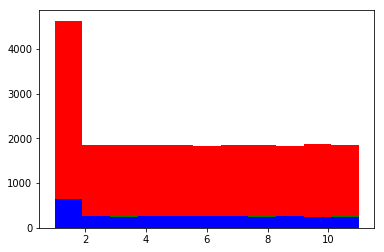

In [12]:
plt.hist(np.array(datasets[0].audio_labels), bins=11, color='r')
plt.hist(np.array(datasets[1].audio_labels), bins=11, color='g')
plt.hist(np.array(datasets[2].audio_labels), bins=11, color='b')

In [13]:
def class_counts(dataset):
    unique_elements, counts_elements = np.unique(datasets[0].audio_labels, return_counts=True)
    return list(zip(unique_elements, counts_elements))

In [14]:
class_counts(datasets[0])

[(1, 4634),
 (2, 1860),
 (3, 1853),
 (4, 1843),
 (5, 1842),
 (6, 1839),
 (7, 1852),
 (8, 1864),
 (9, 1839),
 (10, 1885),
 (11, 1861)]

In [15]:
class_counts(datasets[1])

[(1, 4634),
 (2, 1860),
 (3, 1853),
 (4, 1843),
 (5, 1842),
 (6, 1839),
 (7, 1852),
 (8, 1864),
 (9, 1839),
 (10, 1885),
 (11, 1861)]

In [16]:
class_counts(datasets[2])

[(1, 4634),
 (2, 1860),
 (3, 1853),
 (4, 1843),
 (5, 1842),
 (6, 1839),
 (7, 1852),
 (8, 1864),
 (9, 1839),
 (10, 1885),
 (11, 1861)]

In [17]:
print('Number of silence files in train, dev, test: {0}, {1}, {2}'.format(datasets[0].n_silence,
                                                                          datasets[1].n_silence,
                                                                          datasets[2].n_silence))

Number of silence files in train, dev, test: 4634, 644, 641


In [18]:

train_set, dev_set, test_set = datasets

In [19]:
for d in range(0,5):
    print(len(datasets[0].bg_noise_audio[d]))

988891
978488
960000
980062
1522930


## Training

In [20]:
# https://arxiv.org/pdf/1710.10361.pdf
class SpeechResModel(SerializableModule):
    def __init__(self, config):
        super().__init__()
        n_labels = config["n_labels"]
        n_maps = config["n_feature_maps"]
        self.conv0 = nn.Conv2d(1, n_maps, (3, 3), padding=(1, 1), bias=False)
        if "res_pool" in config:
            self.pool = nn.AvgPool2d(config["res_pool"])

        self.n_layers = n_layers = config["n_layers"]
        dilation = config["use_dilation"]
        if dilation:
            self.convs = [nn.Conv2d(n_maps, n_maps, (3, 3), padding=int(2**(i // 3)), dilation=int(2**(i // 3)), 
                bias=False) for i in range(n_layers)]
        else:
            self.convs = [nn.Conv2d(n_maps, n_maps, (3, 3), padding=1, dilation=1, 
                bias=False) for _ in range(n_layers)]
        for i, conv in enumerate(self.convs):
            self.add_module("bn{}".format(i + 1), nn.BatchNorm2d(n_maps, affine=False))
            self.add_module("conv{}".format(i + 1), conv)
        self.output = nn.Linear(n_maps, n_labels)

    def forward(self, x):
        x = x.unsqueeze(1)
        for i in range(self.n_layers + 1):
            y = F.relu(getattr(self, "conv{}".format(i))(x))
            if i == 0:
                if hasattr(self, "pool"):
                    y = self.pool(y)
                old_x = y
            if i > 0 and i % 2 == 0:
                x = y + old_x
                old_x = x
            else:
                x = y
            if i > 0:
                x = getattr(self, "bn{}".format(i))(x)
        x = x.view(x.size(0), x.size(1), -1) # shape: (batch, feats, o3)
        x = torch.mean(x, 2)
        return self.output(x)

In [21]:
res15 = dict(n_labels=12, use_dilation=True, n_layers=13, n_feature_maps=45)
model = SpeechResModel(res15)

#torch.cuda.set_device(config["gpu_no"])
model.cuda()

SpeechResModel(
  (conv0): Conv2d (1, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv1): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv2): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv3): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv4): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (bn5): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv5): Conv2d (45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (bn6): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False)
  (conv6): Conv2d (45, 45, 

In [23]:
def print_eval(name, scores, labels, loss, end="\n"):
    batch_size = labels.size(0)
    accuracy = (torch.max(scores, 1)[1].view(batch_size).data == labels.data).sum() / batch_size
    loss = loss.cpu().data.numpy()[0]
    print("{} accuracy: {:>5}, loss: {:<25}".format(name, accuracy, loss), end=end)
    return accuracy

def evaluate(config, model, test_loader):
    #torch.cuda.set_device(config["gpu_no"])
    model.eval()
    criterion = nn.CrossEntropyLoss()
    results = []
    total = 0
    for model_in, labels in test_loader:
        model_in = Variable(model_in, requires_grad=False)
        
        model_in = model_in.cuda()
        labels = labels.cuda()
        
        scores = model(model_in)
        labels = Variable(labels, requires_grad=False)
        loss = criterion(scores, labels)
        results.append(print_eval("test", scores, labels, loss) * model_in.size(0))
        total += model_in.size(0)
    print("final test accuracy: {}".format(sum(results) / total))

### Make submission

In [24]:
label2word = {v: k.strip("_") for k, v in words.items()}

In [25]:
label2word

{0: 'silence',
 1: 'unknown',
 2: 'yes',
 3: 'no',
 4: 'up',
 5: 'down',
 6: 'left',
 7: 'right',
 8: 'on',
 9: 'off',
 10: 'stop',
 11: 'go'}

In [26]:
model.load('./../models/model_updated_added_noise_mix.pt')

In [27]:
train_loader = data.DataLoader(train_set, batch_size=config["batch_size"], shuffle=True, drop_last=True)
dev_loader = data.DataLoader(dev_set, batch_size=min(len(dev_set), 16), shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=min(len(test_set), 16), shuffle=True)

In [28]:
eval_folder = "./../raw_data/test/audio/"
eval_wavs = {
    os.path.join(eval_folder, file_path): os.path.join(eval_folder, file_path) # TODO: this is hack, be careful
        for file_path in os.listdir("./../raw_data/test/audio/")
            if file_path.endswith(".wav")
}

In [29]:
len(eval_wavs)

158538

In [30]:
eval_set = SpeechDataset(eval_wavs, DatasetType.TEST, test_cfg)
eval_loader = data.DataLoader(eval_set, batch_size=16)

In [31]:
with open("../check.txt", "w") as sub:
    i=0
    probs_lst = ['prob_' + str(i) for i in range(0, 12)]
    sub.write("fname," + ','.join(str(prob) for prob in probs_lst) + ",label" + "\n")
    for model_in, labels in test_loader:
        scores = model(Variable(model_in, requires_grad=False).cuda())
        labels = labels.cuda()
        labels = Variable(labels, requires_grad=False)
        for wav in range(scores.shape[0]):
            current_wav = test_loader.dataset.audio_files[i+wav].rsplit("/")[-1]
            wav_probs = ','.join(str(float(score)) for score in scores[wav])
            to_fill_row = current_wav + ',' + wav_probs + ',' + str(int(labels[wav])) + "\n"
            sub.write(
                to_fill_row
            )
        i+=16

KeyboardInterrupt: 

In [32]:
with open("../probs_model_updated_added_noise_mix.txt", "w") as sub:
    probs_lst = ['prob_' + str(i) for i in range(0, 12)]
    sub.write("fname," + ','.join(str(prob) for prob in probs_lst) + "\n")
    for model_in, wav_paths in eval_loader:
        scores = model(Variable(model_in, requires_grad=False).cuda())
        for wav in range(scores.shape[0]):
            current_wav = wav_paths[wav].rsplit("/")[-1]
            wav_probs = ','.join(str(float(score)) for score in scores[wav])
            to_fill_row = current_wav + ',' + wav_probs + "\n"
            sub.write(
                to_fill_row
            )

KeyboardInterrupt: 

In [33]:
check = pd.read_csv('../probs_model_updated_added_noise_mix.txt')

In [30]:
print(label2word[int(scores[4].max(0)[1])])

left


In [37]:
play_wav(wav_paths[4])